# Daily maxima

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import box

YEARS = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

def label_gridpoints(df):
    grid_ids = df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).agg(sum).reset_index()
    grid_ids = {(row.latitude, row.longitude): row.Index for row in grid_ids.itertuples()}
    df['grid'] = df.apply(lambda row: grid_ids[(row.latitude, row.longitude)], axis=1)
    return df


def pivot_observations(df, value):
    df = df[['time', 'cyclone_flag', 'grid', value]]
    df = df.dropna()
    df = df.pivot(index=['time', 'cyclone_flag'], columns=['grid'], values=[value])
    df.columns = df.columns.get_level_values(1)
    return df


data = "precip_data"
indir = f"/Users/alison/Documents/DPhil/data/era5/{data}"
outdir = f"/Users/alison/Documents/DPhil/multivariate/{data}"

In [2]:
#### Get precip data in yearly files
ds = xr.open_dataset(os.path.join(indir, 'bangladesh_2013-2022.nc'))
df = ds.to_dataframe().reset_index()
df['year'] = df['time'].dt.year

for year in df['year'].unique():
    df_year = df[df['year'] == year]
    df_year = df_year.drop(columns='year')
    ds_year = df_year.to_xarray()
    ds_year.to_netcdf(os.path.join(indir, f"bangladesh_{year}.nc"))

# Try it out with one year

# Create file for all years

In [3]:
# setup
# load ibtracs within mask
YEAR = YEARS[0]
ds = xr.open_dataset(os.path.join(indir, f'bangladesh_{YEAR}.nc'))
df = ds.to_dataframe().reset_index()
df = df.fillna(0.)
xmin, xmax = df['longitude'].min(), df['longitude'].max()
ymin, ymax = df['latitude'].min(), df['latitude'].max()
print(f"Longitude bounds: [{xmin}, {xmax}]")
print(f"Latitude bounds: [{ymin}, {ymax}]")
mask = box(xmin, ymin, xmax, ymax)
ibtracs = gpd.read_file('/Users/alison/Documents/DPhil/data/ibtracs/ibtracs_since1980_points.gpkg', mask=mask)

# get dailymax values
df_dailymax = df.groupby(['latitude', 'longitude', pd.Grouper(key='time', freq='D')]).agg(max).reset_index()
df_dailymax = label_gridpoints(df_dailymax)

# save coordinates
gdf = gpd.GeoDataFrame(df_dailymax, geometry=gpd.points_from_xy(df_dailymax.longitude, df_dailymax.latitude))
gdf_coords = gdf[['grid', 'longitude', 'latitude', 'geometry']].drop_duplicates()
gdf_coords = gdf_coords.reset_index(drop=True).set_crs(4326)
gdf_coords.to_file(os.path.join(outdir, "dailymax_coords.gpkg"), driver='GPKG')
coords_dict = {(x.latitude, x.longitude): x.grid for x in gdf_coords.itertuples()}

Longitude bounds: [80.0, 95.0]
Latitude bounds: [10.0, 25.0]


In [4]:
# cycle through all years
for YEAR in YEARS:
    if os.path.exists(os.path.join(indir, f'bangladesh_{YEAR}.nc')):
        if not os.path.exists(os.path.join(outdir, f"tp_dailymax_{YEAR}.csv")):
            ds = xr.open_dataset(os.path.join(indir, f'bangladesh_{YEAR}.nc'))
            df = ds.to_dataframe().reset_index()
            df = df.fillna(0.)

            df_dailymax = df.groupby(['latitude', 'longitude', pd.Grouper(key='time', freq='D')]).agg(max).reset_index()
            df_dailymax['grid'] = df_dailymax.apply(lambda row: coords_dict[row.latitude, row.longitude], axis=1)
            
            # load IBTrACs to add cyclone flag
            ibtracs_year = ibtracs[ibtracs['SEASON'] == YEAR].copy()
            storm_times = [*pd.to_datetime(ibtracs_year['ISO_TIME'])]
            df_dailymax['cyclone_flag'] = df_dailymax['time'].isin(storm_times)
            
            df_tp = pivot_observations(df_dailymax, 'tp')
            df_tp.to_csv(os.path.join(outdir, f"tp_dailymax_{YEAR}.csv"))
                
        else:
            print(f"{YEAR} already processed.")
    else:
        print(f"No file for {YEAR}")
!say done

2013 already processed.
2014 already processed.
2015 already processed.
2016 already processed.
2017 already processed.
2018 already processed.
2019 already processed.
2020 already processed.
2021 already processed.
2022 already processed.


In [5]:
# concatenate them all
dfs_tp = []
for YEAR in YEARS:
    if os.path.exists(os.path.join(outdir, f"tp_dailymax_{YEAR}.csv")):
        df_tp = pd.read_csv(os.path.join(outdir, f"tp_dailymax_{YEAR}.csv"))
        dfs_tp.append(df_tp)

df_tp = pd.concat(dfs_tp).reset_index(drop=True)
df_tp.to_csv(os.path.join(outdir, f"tp_dailymax.csv"))

## EDA

In [6]:
import matplotlib.pyplot as plt

df_tp = pd.read_csv(os.path.join(outdir, f"tp_dailymax.csv"), index_col=[0])
df_tp['time'] = pd.to_datetime(df_tp['time'])
df_ts = df_tp.set_index('time')

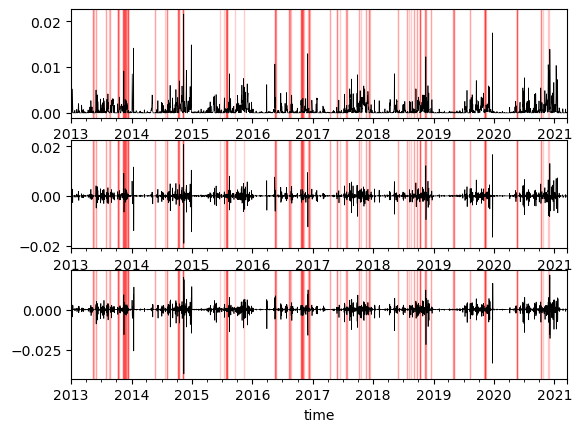

In [7]:
line_kwargs = {'color': 'k', 'linewidth': .5}
node = '3'
n = 3000

fig, ax = plt.subplots(3, 1)

df_ts[node].head(n).plot(ax=ax[0], **line_kwargs);
df_ts[node].diff().head(n).plot(ax=ax[1], **line_kwargs);
df_ts[node].diff().diff().head(n).plot(ax=ax[2], **line_kwargs);

for time in df_ts.query('cyclone_flag').index.values:
    ax[0].axvline(x=time, color='red', lw=1, alpha=.2, zorder=0)
    ax[1].axvline(x=time, color='red', lw=1, alpha=.2, zorder=0)
    ax[2].axvline(x=time, color='red', lw=1, alpha=.2, zorder=0)
    
!say done

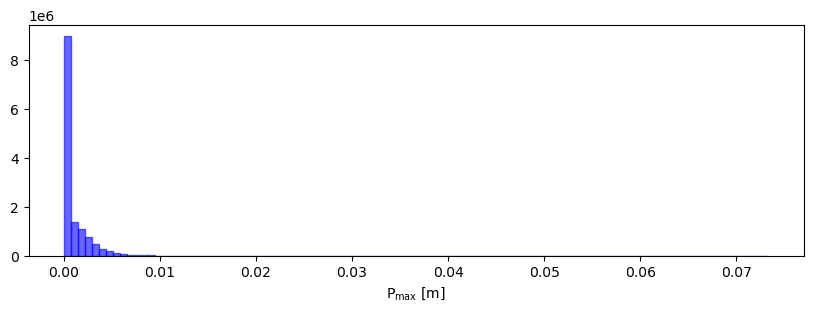

In [8]:
import numpy as np
import matplotlib.pyplot as plt
hist_kwargs = {'color': 'blue', 'alpha': .6, 'edgecolor': 'blue'}

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.hist(df_tp.iloc[:, 2:].values.ravel(), bins=100, **hist_kwargs)
ax.set_xlabel('P$_{\max}$ [m]');

# Visualise

In [9]:
import os
import matplotlib.pyplot as plt
from shapely.geometry import box

cyclone = True
df_tp = pd.read_csv(os.path.join(outdir, f"tp_dailymax.csv"), index_col=[0])

df_tp['cyclone_flag'].unique()
# df_tp = df_tp[df_tp['cyclone_flag']==cyclone]
tp_df = df_tp.iloc[:, 2:].transpose()
tp_df = tp_df.reset_index(names='grid')

In [10]:
tp_df

,grid,0,1,2,3,4,5,6,7,8,...,3642,3643,3644,3645,3646,3647,3648,3649,3650,3651
0,0,0.000059,0.000010,0.000000,0.000016,0.000011,0.000019,0.001289,0.003725,0.001590,...,0.000756,0.000267,0.000736,0.001177,0.000986,0.000460,0.000219,0.000045,0.000079,0.000003
1,1,0.000065,0.000007,0.000000,0.000013,0.000017,0.000034,0.001095,0.004221,0.001280,...,0.000443,0.000418,0.001004,0.001137,0.001150,0.000461,0.000241,0.000090,0.000126,0.000006
2,2,0.000051,0.000006,0.000000,0.000010,0.000013,0.000021,0.001011,0.005270,0.003079,...,0.000616,0.000482,0.001205,0.001064,0.001110,0.000517,0.000229,0.000115,0.000132,0.000015
3,3,0.000107,0.000003,0.000001,0.000039,0.000028,0.000022,0.002770,0.005205,0.003067,...,0.000844,0.000350,0.001101,0.001256,0.000819,0.000456,0.000198,0.000126,0.000145,0.000048
4,4,0.000049,0.000007,0.000022,0.000020,0.000044,0.000038,0.004582,0.003332,0.003941,...,0.000790,0.000436,0.000868,0.001242,0.000995,0.000472,0.000291,0.000126,0.000111,0.000136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,3716,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000230,0.000110,0.000000,...,0.000000,0.000000,0.000007,0.000000,0.001154,0.001359,0.000075,0.000011,0.000003,0.000019
3717,3717,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000199,0.000130,0.000000,...,0.000000,0.000000,0.000011,0.000000,0.000122,0.000441,0.000055,0.000015,0.000004,0.000035
3718,3718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000066,0.000207,0.000000,...,0.000000,0.000000,0.000012,0.000000,0.000209,0.001287,0.000081,0.000015,0.000001,0.000020
3719,3719,0.000034,0.000008,0.000051,0.000021,0.000021,0.000000,0.000021,0.000072,0.000000,...,0.000022,0.000112,0.000008,0.000062,0.000209,0.000405,0.000170,0.000233,0.000048,0.000148


In [11]:
coords_dict
lon_dict_r = {grid: coords[1] for coords, grid in coords_dict.items()}
lat_dict_r = {grid: coords[0] for coords, grid in coords_dict.items()}
tp_df['lon'] = tp_df['grid'].astype(int).map(lon_dict_r)
tp_df['lat'] = tp_df['grid'].astype(int).map(lat_dict_r)

tp_gdf = gpd.GeoDataFrame(tp_df, geometry=gpd.points_from_xy(tp_df['lon'], tp_df['lat']))

In [12]:
# also visualise nearby coastline
coastline = gpd.read_parquet("/Users/alison/Documents/DPhil/data/openstreetmap/coastlines-osm.parquet")
coastline = coastline.to_crs(4326)
mask = box(*tp_gdf.total_bounds)
coastline = coastline.clip(mask)

/Users/alison/mambaforge/envs/general/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


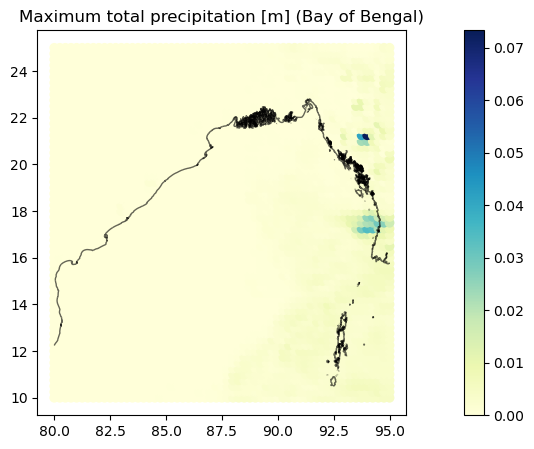

In [13]:
# plot most extremely large conditions
i = tp_gdf.iloc[:, 1:-4].max(axis=0).idxmax()
# print(f"{i}: {tp_gdf.iloc[:, :-1].max(axis=0).max():.2f} m")

fig, ax = plt.subplots(figsize=(15, 5))

tp_gdf.plot(i, cmap='YlGnBu', alpha=1, ax=ax, legend=True)
coastline.plot(color='k', linewidth=1, alpha=.6, ax=ax)
ax.set_title('Maximum total precipitation [m] (Bay of Bengal)');
# fig.savefig(os.path.join("/Users/alison/Documents/DPhil/multivariate/evtGAN_code&data/figures", 'max_real_bgd.png'))